In [44]:
import datetime
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("whitegrid")
seaborn.despine()
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

In [45]:
def market_design(param):
    # Create a range of ratio
    ratios = numpy.linspace(1, param['ratio_end'], num=param['ratio_num'])

    # Create vectors
    sells = []
    buys = []
    PVprods = []
    LOADconss = []
    for ratio in ratios:
        # Fake Load and PV
        PVprod = 10
        LOADcons = ratio * PVprod /100
#         LOADcons = 10
#         PVprod = LOADcons * 100 / ratio

        # Clear price
        buy, sell = ratio_to_price(ratio, param)
        sells.append(sell)
        buys.append(buy)
        PVprods.append(PVprod)
        LOADconss.append(LOADcons)
    
    # Create plots
    plot_prices(ratios, sells, buys, PVprods, LOADconss, param)

def ratio_to_price(ratio, param):
    """Clearing price mechanism"""
    # Retailing price $/kW
    pge_buy = param['pge_buy']
    pge_sell = param['pge_sell']

    # Upper/lower margin coef
    upper_ratio = param['upper_ratio']
    lower_ratio = param['lower_ratio']

    # Maximum local electricity price
    minimum_local_sell = param['minimum_local_sell']

    # Minimum local electricity prices
    maximum_local_buy = param['maximum_local_buy']

    # If no feed back to main grid
    if ratio >= upper_ratio:
        # Selling price
        sell = minimum_local_sell

        # Buying price
        # buy = ((maximum_local_sell * PVprod) + (pge * (LOADcons - PVprod))) / LOADcons
        buy = int(sell * 100 / ratio) + pge_sell - int(pge_sell * 100 /ratio)

    # RE production is around 66%
    elif ratio < upper_ratio and ratio > lower_ratio:
        # Selling price
        a = int((minimum_local_sell - maximum_local_buy) * 100 / (upper_ratio - lower_ratio))
        b = 100 * maximum_local_buy - int(a * lower_ratio)
        sell = int((a * ratio + b) / 100)

        # Buying price
#         a = (maximum_local_buy - minimum_local_buy) / (upper_ratio - lower_ratio)
#         b = minimum_local_buy - a * lower_ratio
#         buy = a * ratio + b
        buy = int(sell * 100 /ratio) + pge_sell - int(pge_sell * 100 /ratio)

    # RE production is bigger than local needs
    else:
        buy = maximum_local_buy
        sell = int(buy * ratio / 100) + pge_buy - int(pge_buy * ratio / 100)


    return buy, sell

def plot_prices(ratios, sells, buys, PVprods, LOADconss, param):
    # Check buy and sell match
    localProdPrice = [PVprods[i] * sells[i] for i in range(0, len(sells))]
    pgePrice = [(LOADconss[i] - PVprods[i]) * param['pge_sell'] 
                if (LOADconss[i] - PVprods[i]) >= 0 
                else (LOADconss[i] - PVprods[i]) * param['pge_buy'] 
                for i in range(0, len(sells))]
    localConsPrice = [LOADconss[i] * buys[i] for i in range(0, len(sells))]
    totalConsPrice = [localProdPrice[i] + pgePrice[i] for i in range(0, len(ratios))]

    # Plot price for different ratios
    plt.figure(figsize=(11, 5), dpi=200)
    plt.plot(ratios, buys, label='Local buy price', linewidth=3)
    plt.plot(ratios, sells, label='Local sell price', linewidth=3)
    plt.plot(ratios, [param['pge_sell']] * len(ratios), '--', label='Utility sell price', linewidth=2.5)
    plt.plot(ratios, [param['pge_buy']] * len(ratios), '--',label='Utility buy price', linewidth=2.5)
    plt.ylim([60, 200])
    plt.ylabel('Price [$/kWh]')
    plt.xlabel('Ratio [Consumption/Generation]')
    plt.legend(loc=0)

    # Plot 
    plt.figure(figsize=(11, 5), dpi=200)
    plt.plot(LOADconss, localProdPrice, label='Local energy payment', linewidth=3)
    plt.plot(LOADconss, pgePrice, label='Utility energy payment', linewidth=3)
    plt.plot(LOADconss, localConsPrice, label='Local energy payment', linewidth=2)
    plt.plot(LOADconss, totalConsPrice, label='Utility and local producer payment', linewidth=10, alpha=0.3)
    plt.ylabel('Price $')
    plt.xlabel('Load demand if generation is set to 10kWh [kWh]')
    plt.legend(loc=0)
    plt.show()


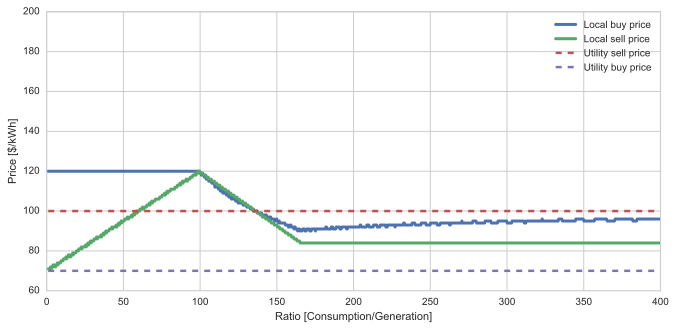

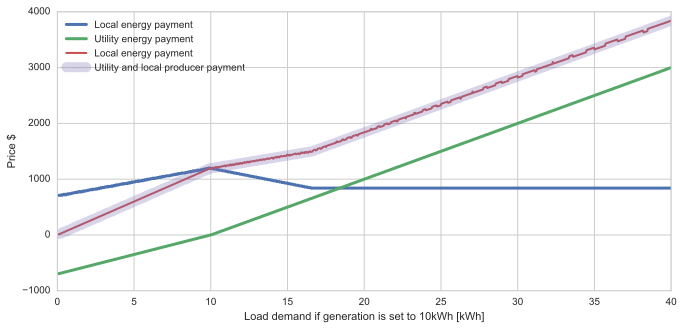

In [46]:
param = {}

# Retailing price $/kW
param['pge_sell'] = 100
param['pge_buy'] = 70

# Upper/lower margin coef
param['upper_ratio'] = 166
param['lower_ratio'] = 100

# Maximum local electricity price
param['minimum_local_sell'] = 1.2 * param['pge_buy']

# Minimum local electricity prices
param['maximum_local_buy'] = 1.2 * param['pge_sell']

# bonus
param['ratio_end'] = 400
param['ratio_num'] = 1000

market_design(param)